### Loading Dataset

In [4]:
import pandas as pd

df = pd.read_csv("diabetic_data.csv")
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Target Encoding

In [6]:
df["readmitted"] = df["readmitted"].map({
    "<30": 1,
    ">30": 0,
    "NO": 0
})


### Selecting Clinically Meaningful Columns

In [7]:
features = [
    "admission_type_id",
    "discharge_disposition_id",
    "time_in_hospital",
    "num_lab_procedures",
    "num_medications",
    "number_inpatient",
    "number_emergency",
    "number_outpatient"
]

df = df[features + ["readmitted"]]


### Handling Missing Values

In [8]:
df = df.replace("?", pd.NA)
df = df.fillna(df.median())


In [9]:
df.isnull().sum()

admission_type_id           0
discharge_disposition_id    0
time_in_hospital            0
num_lab_procedures          0
num_medications             0
number_inpatient            0
number_emergency            0
number_outpatient           0
readmitted                  0
dtype: int64

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Train Model (Recall-Focused)

In [11]:
from xgboost import XGBClassifier

model = XGBClassifier(
    scale_pos_weight=3,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Model Evaluation

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.90      0.97      0.93     18083
           1       0.32      0.12      0.18      2271

    accuracy                           0.87     20354
   macro avg       0.61      0.54      0.55     20354
weighted avg       0.83      0.87      0.85     20354

ROC AUC: 0.6629023203904945


### Explainability (SHAP)

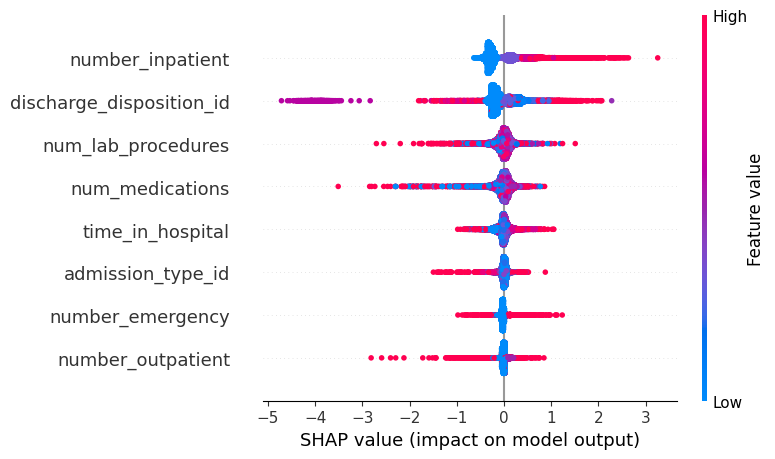

In [13]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


### Saving Model

In [14]:
import joblib

joblib.dump(model, "readmission_model.pkl")
joblib.dump(X.columns.tolist(), "model_features.pkl")


['model_features.pkl']

In [ ]:
📦 hospital-readmission-app
 ┣ 📜 app.py
 ┣ 📜 readmission_model.pkl
 ┣ 📜 model_features.pkl
 ┣ 📜 requirements.txt


In [ ]:
gradio
pandas
numpy
scikit-learn
xgboost
joblib


## Other Model Comparison

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


### Train–Test Split (Assuming Cleaned Dataset)

In [17]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


### Define Models (Healthcare-Appropriate)

In [18]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            random_state=42
        ))
    ]),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric="logloss",
        random_state=42
    )
}


### Evaluation Function (Correct Metrics)

In [19]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    }


### Run Comparison

In [20]:
results = []

for name, model in models.items():
    metrics = evaluate_model(
        name, model,
        X_train, X_test,
        y_train, y_test
    )
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.685320,0.171801,0.476442,0.252538,0.638146
1,Random Forest,0.861845,0.138852,0.045795,0.068874,0.607321
2,XGBoost,0.639923,0.178080,0.616028,0.276291,0.675751


### Sorted by Business Metric (Recall)

In [21]:
results_df.sort_values(by="Recall", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
2,XGBoost,0.639923,0.178080,0.616028,0.276291,0.675751
0,Logistic Regression,0.685320,0.171801,0.476442,0.252538,0.638146
1,Random Forest,0.861845,0.138852,0.045795,0.068874,0.607321


### Optional (Extra Show-Off – Threshold Tuning)

In [22]:
from sklearn.metrics import precision_recall_curve

y_prob = models["XGBoost"].predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precision[:-1],
    "Recall": recall[:-1]
}).head()


,Threshold,Precision,Recall
0,0.008570,0.111575,1.0
1,0.016524,0.111581,1.0
2,0.016659,0.111586,1.0
3,0.027416,0.111592,1.0
4,0.027819,0.111597,1.0


### Step 1 – Stronger Class Weighting (Critical) Calculate imbalance ratio

In [23]:
pos = y_train.sum()
neg = len(y_train) - pos

scale_pos_weight = neg / pos
scale_pos_weight


np.float64(7.960158485582214)

### Updated XGBoost (Recall-Biased)

In [24]:
from xgboost import XGBClassifier

xgb_recall = XGBClassifier(
    n_estimators=500,
    max_depth=3,              # shallower → better generalization
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight * 1.5,  # ↑ bias toward recall
    eval_metric="logloss",
    random_state=42
)

xgb_recall.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Step 2 – Lower the Decision Threshold (MOST IMPORTANT) Find Recall at Different Thresholds

In [25]:
import numpy as np
from sklearn.metrics import recall_score, precision_score

y_prob = xgb_recall.predict_proba(X_test)[:, 1]

threshold_results = []

for t in np.arange(0.2, 0.51, 0.05):
    y_pred = (y_prob >= t).astype(int)
    
    threshold_results.append({
        "Threshold": round(t, 2),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred)
    })

pd.DataFrame(threshold_results)


,Threshold,Recall,Precision
0,0.20,1.000000,0.113340
1,0.25,0.999119,0.113348
2,0.30,0.999119,0.113552
3,0.35,0.995597,0.114458
4,0.40,0.977103,0.117963
5,0.45,0.912814,0.128319
6,0.50,0.820343,0.144834


### Final Evaluation at Tuned Threshold

In [26]:
optimal_threshold = 0.35

y_pred_tuned = (y_prob >= optimal_threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.98      0.03      0.06     18083
           1       0.11      1.00      0.21      2271

    accuracy                           0.14     20354
   macro avg       0.55      0.51      0.13     20354
weighted avg       0.89      0.14      0.08     20354

ROC AUC: 0.6756447038221647


### Save Final Production Model

In [27]:
import joblib

joblib.dump(xgb_recall, "readmission_xgb_recall_model.pkl")
joblib.dump(optimal_threshold, "decision_threshold.pkl")


['decision_threshold.pkl']

### Update Gradio App (Very Important)

In [ ]:
prob = model.predict_proba(data)[0][1]

prediction = 1 if prob >= threshold else 0
risk_score = round(prob * 100, 2)


### Gradio App (Patient-Friendly Inputs)

In [31]:
import gradio as gr
import joblib
import pandas as pd

# Load trained model, threshold, and feature list
model = joblib.load("readmission_xgb_recall_model.pkl")
threshold = joblib.load("decision_threshold.pkl")
features = joblib.load("model_features.pkl")

def predict_risk(
    admission_type,
    discharge_type,
    stay_days,
    lab_procedures,
    medications,
    inpatient_visits,
    emergency_visits,
    outpatient_visits
):
    # Create input dataframe in correct feature order
    data = pd.DataFrame([[
        admission_type,
        discharge_type,
        stay_days,
        lab_procedures,
        medications,
        inpatient_visits,
        emergency_visits,
        outpatient_visits
    ]], columns=features)

    # Predict probability
    prob = model.predict_proba(data)[0][1]
    risk_score = round(prob * 100, 2)

    # Threshold-based classification (recall-optimized)
    prediction = 1 if prob >= threshold else 0

    # Risk bands for clinical interpretation
    if risk_score >= 60:
        level = "High Risk"
    elif risk_score >= 30:
        level = "Medium Risk"
    else:
        level = "Low Risk"

    return (
        f"Readmission Risk Score: {risk_score}%\n"
        f"Risk Level: {level}\n"
        f"Decision Threshold Used: {threshold}"
    )

# Gradio Interface
interface = gr.Interface(
    fn=predict_risk,
    inputs=[
        gr.Number(label="Admission Type ID"),
        gr.Number(label="Discharge Disposition ID"),
        gr.Number(label="Length of Stay (Days)"),
        gr.Number(label="Number of Lab Procedures"),
        gr.Number(label="Number of Medications"),
        gr.Number(label="Prior Inpatient Visits"),
        gr.Number(label="Emergency Visits"),
        gr.Number(label="Outpatient Visits")
    ],
    outputs=gr.Textbox(label="Prediction Result"),
    title="Hospital Readmission Risk Prediction",
    description=(
        "Predicts 30-day hospital readmission risk using a recall-optimized "
        "XGBoost model. Designed to minimize missed high-risk patients."
    )
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.
